In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np

In [62]:
from pathlib import Path
path = Path("/lustre/groups/ml01/workspace/moscot_paper/mapping/atac/human")
features = pd.read_csv(path/"exprMatrix.tsv.gz", sep="\t", index_col=0).T
metadata = pd.read_csv(path/"meta.tsv", sep="\t", index_col=0)
atac_umap = pd.read_csv(path/"ATAC_UMAP.coords.tsv.gz", sep="\t", header=None, index_col=0)
rna_umap = pd.read_csv(path/"RNA_UMAP.coords.tsv.gz", sep="\t", header=None, index_col=0)
spots = pd.read_csv(path/"Spots.coords.tsv.gz", sep="\t", index_col=0, header=None)

In [63]:
rna = features.loc[:, ~features.columns.str.contains("atac")]
atac = features.loc[:, features.columns.str.contains("atac")]
rna.shape, atac.shape

((2500, 21179), (2500, 24768))

In [86]:
adata_rna = ad.AnnData(X=rna.values, obs=metadata, obsm={"X_umap_original": rna_umap.values, "spatial": spots.values})
adata_rna.var_names = rna.columns
adata_atac = ad.AnnData(X=atac.values, obs=metadata, obsm={"X_umap_original": atac_umap.values, "spatial": spots.values})
adata_atac.var_names = atac.columns
sc.pp.highly_variable_genes(adata_rna, n_top_genes=5000, subset=True)
sc.pp.highly_variable_genes(adata_atac, n_top_genes=5000, subset=True)
sc.tl.rank_genes_groups(adata_atac, groupby="ATAC_clusters", method="wilcoxon")
atac_peaks = []
for cluster in adata_atac.obs.ATAC_clusters.cat.categories:
    df = sc.get.rank_genes_groups_df(adata_atac, group=cluster)
    atac_peaks += df.names[0:10].tolist()

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axi

In [87]:
sc.pp.pca(adata_rna)
sc.pp.pca(adata_atac)
sc.pp.neighbors(adata_rna)
sc.pp.neighbors(adata_atac)
sc.tl.umap(adata_rna)
sc.tl.umap(adata_atac)

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


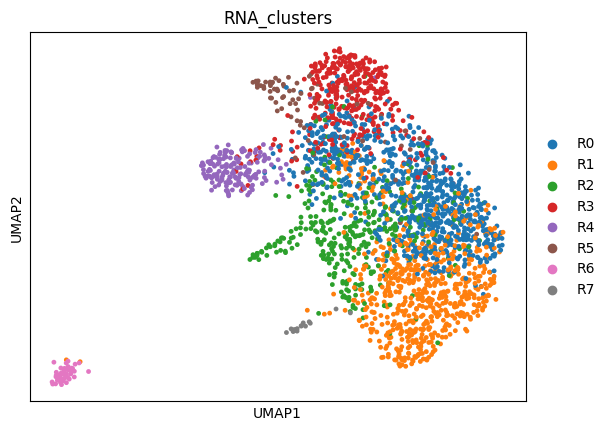

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


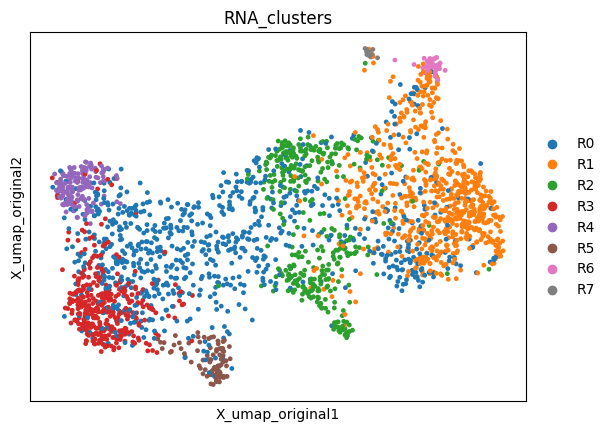

In [88]:
sc.pl.umap(adata_rna, color="RNA_clusters")
sc.pl.embedding(adata_rna, color="RNA_clusters", basis="X_umap_original")

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


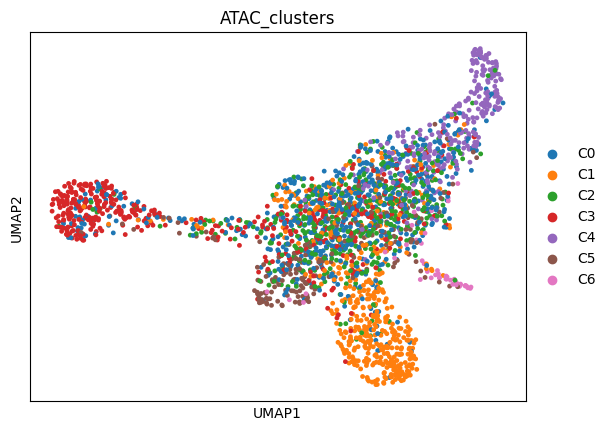

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


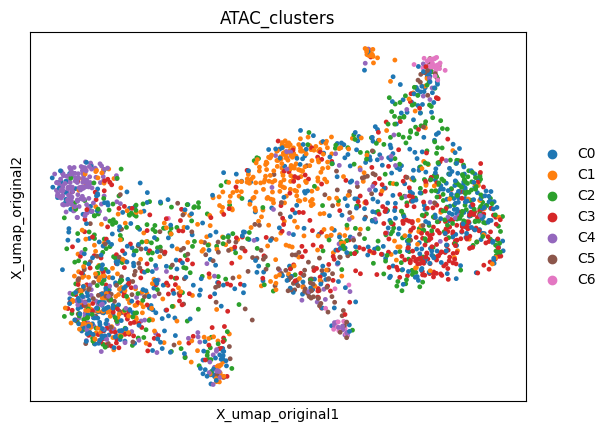

In [89]:
sc.pl.umap(adata_atac, color="ATAC_clusters")
sc.pl.embedding(adata_atac, color="ATAC_clusters", basis="X_umap_original")

In [90]:
adata_rna.uns["marker_peaks"] = atac_peaks
adata_rna.write("/lustre/groups/ml01/workspace/moscot_paper/mapping/atac/RNA.h5ad")
adata_atac.write("/lustre/groups/ml01/workspace/moscot_paper/mapping/atac/ATAC.h5ad")

In [29]:
np.testing.assert_array_equal(adata_rna.obs.index, adata_atac.obs.index)

In [10]:
import moscot as mt


In [93]:
adata_atac.var_names

Index(['atac-NR2F2', 'atac-SSBP4', 'atac-GNA11', 'atac-SLC6A9', 'atac-MIR92B',
       'atac-FOXM1', 'atac-VIPAS39', 'atac-SOX8', 'atac-ANKRD13B',
       'atac-MMP28',
       ...
       'atac-LOC100129603', 'atac-NCRNA00250', 'atac-MIR513A1', 'atac-MIR6124',
       'atac-GLB1L2', 'atac-KRT6A', 'atac-LINC01069', 'atac-SLC2A4',
       'atac-PRMT1', 'atac-MIR6837'],
      dtype='object', length=5000)

In [94]:
adata_rna.obsm["spatial"] = np.hstack([adata_atac.obsm["X_pca"], adata_atac.obsm["spatial"]])
adata_rna.obsm["X_pca_ATAC"] = adata_atac.obsm["X_pca"]
adata_rna.obsm["ATAC"] = pd.DataFrame(adata_atac.X.copy(), columns=adata_atac.var_names.values, index=adata_rna.obs_names)
adata_sc = sc.pp.subsample(adata_rna, fraction=0.5, copy=True, random_state=42)
adata_sp = adata_rna[~np.in1d(adata_rna.obs_names, adata_sc.obs_names)].copy()
mp = mt.problems.space.MappingProblem(adata_sc=adata_sc, adata_sp = adata_sp)

In [102]:
mp = mp.prepare(
        sc_attr={"attr": "obsm", "key": "X_pca_ATAC"},
        joint_attr={"attr": "X"},
        spatial_key="spatial",
        normalize_spatial=False,
    )

In [103]:
mp = mp.solve()

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(1250, 1250)].                                          


In [104]:
mp

MappingProblem[('src', 'tgt')]

In [112]:
cell_trans = mp.cell_transition(source="src", target="tgt", aggregation_mode="annotation", source_groups="ATAC_clusters", target_groups="ATAC_clusters",)
np.diag(cell_trans).mean()

/home/icb/giovanni.palla/code/moscot/src/moscot/base/problems/_mixins.py:506: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_dist = df[df[annotation_key].isin(annotations_2)].groupby(annotation_key).sum(numeric_only=True)
/home/icb/giovanni.palla/code/moscot/src/moscot/base/problems/_mixins.py:506: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_dist = df[df[annotation_key].isin(annotations_2)].groupby(annotation_key).sum(numeric_only=True)
/home/icb/giovanni.palla/code/moscot/src/moscot/base/problems/_mixins.py:506: FutureWarning: The default of observed=False is deprecated and will be changed to True

0.17582480450429486

In [35]:
np.diag(cell_trans)

array([0.2642041 , 0.29574678, 0.25305763, 0.12128417, 0.17166083,
       0.06460541, 0.06826581])

In [111]:
mt.plotting.cell_transition(mp)

KeyError: "No data found in `adata.uns['moscot_results']['cell_transition']['cell_transition']`."

In [106]:
atac = adata_sc.obsm["ATAC"].loc[:,adata_sc.uns["marker_peaks"]].values
spatial_atac = mp.problems[("src", "tgt")].solution.pull(
        atac,
        scale_by_marginals=True,
    )

In [110]:
atac_predicted = pd.DataFrame(spatial_atac, columns=adata_sc.uns["marker_peaks"], index=adata_sp.obs_names)